![](https://datasciencebowl.com/wp-content/uploads/2019/03/dsb-logo-400.png)

Data Science Bowl is the world’s largest data science competition focused on social good. Each year, this competition gives Kagglers a chance to use their passion to change the world. Over the last four years, more than 50,000+ Kagglers have submitted over 114,000+ submissions, to improve everything from lung cancer and heart disease detection to ocean health.

Inspired by Ragnar's Kernel, https://www.kaggle.com/ragnar123/adversarial-validation-and-model <br/>
Lets Minify the DSB data for building ML Models using Adversarial Feature Selection Technique

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('../mnt/inputs/origin/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('../mnt/inputs/origin/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('../mnt/inputs/origin/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('../mnt/inputs/origin/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('../mnt/inputs/origin/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    '''
    - titile_event_code を all_title_event_code
    - 
    
    '''
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = sorted(list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique())))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = sorted(list(set(train['title'].unique()).union(set(test['title'].unique()))))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = sorted(list(set(train['event_code'].unique()).union(set(test['event_code'].unique()))))
    list_of_event_id = sorted(list(set(train['event_id'].unique()).union(set(test['event_id'].unique()))))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = sorted(list(set(train['world'].unique()).union(set(test['world'].unique()))))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = sorted(list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(
        set(test[test['type'] == 'Assessment']['title'].value_counts().index))))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100 * np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])

    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [6]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features['installation_session_count'] = sessions_count
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [7]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [8]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [9]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        
    return reduce_train, reduce_test

In [10]:
def Model1_LgbStratified(reduce_train, reduce_test, usefull_features, n_splits, bags=1):
    for seed in range(bags):
        kf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = seed)
        target = 'accuracy_group'
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        oof_pred_val= np.zeros((len(reduce_train), ))
        feature_importance_df_1 = pd.DataFrame()
        for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, reduce_train[target])):
            print('Fold {}'.format(fold + 1))
            x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
            y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
            train_set = lgb.Dataset(x_train, y_train, categorical_feature=categoricals)
            val_set = lgb.Dataset(x_val, y_val, categorical_feature=categoricals)

            params = {'n_estimators':5000,
                      'boosting_type': 'gbdt',
                      'objective': 'regression',
                      'metric': 'rmse',
                      'subsample': 0.75,
                      'subsample_freq': 1,
                      'learning_rate': 0.01,
                      'feature_fraction': 0.9,
                      'max_depth': 15,
                      'lambda_l1': 1,  
                      'lambda_l2': 1,
                      'verbose': 100,
                      'early_stopping_rounds': 100,
                      'seed': seed
                        }

            model = lgb.train(params, train_set, num_boost_round = 1000000, early_stopping_rounds = 300, 
                              valid_sets=[train_set, val_set], verbose_eval = 100)
            oof_pred[val_ind] = model.predict(x_val)
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = features
            fold_importance_df["importance"] = model.feature_importance()
            fold_importance_df["fold"] = fold + 1
            feature_importance_df_1 = pd.concat([feature_importance_df_1, fold_importance_df], axis=0)
            oof_pred_val[val_ind]+= model.predict(x_val)/ n_splits / bags
            y_pred += model.predict(reduce_test[usefull_features]) / n_splits / bags
        _, loss_score, _ = eval_qwk_lgb_regr(reduce_train[target], oof_pred)
    print('Our oof cohen kappa score is: ', loss_score)

    return y_pred,oof_pred_val, feature_importance_df_1

In [11]:
def Model2_GroupKFold(reduce_train, reduce_test, usefull_features, n_splits, bags=1):
    for seed in range(bags):
        kf = GroupKFold(n_splits=n_splits)
        target = 'accuracy_group'
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        oof_pred_val= np.zeros((len(reduce_train), ))
        feature_importance_df_1 = pd.DataFrame()
        for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, groups = reduce_train['installation_id'])):
            print('Fold {}'.format(fold + 1))
            x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
            y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
            train_set = lgb.Dataset(x_train, y_train, categorical_feature=categoricals)
            val_set = lgb.Dataset(x_val, y_val, categorical_feature=categoricals)

            params = {'n_estimators':5000,
                      'boosting_type': 'gbdt',
                      'objective': 'regression',
                      'metric': 'rmse',
                      'subsample': 0.75,
                      'subsample_freq': 1,
                      'learning_rate': 0.01,
                      'feature_fraction': 0.9,
                      'max_depth': 15,
                      'lambda_l1': 1,  
                      'lambda_l2': 1,
                      'verbose': 100,
                      'early_stopping_rounds': 100,
                      'seed': seed
                        }

            model = lgb.train(params, train_set, num_boost_round = 1000000, early_stopping_rounds = 300, 
                              valid_sets=[train_set, val_set], verbose_eval = 100)
            oof_pred[val_ind] = model.predict(x_val)
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = features
            fold_importance_df["importance"] = model.feature_importance()
            fold_importance_df["fold"] = fold + 1
            feature_importance_df_1 = pd.concat([feature_importance_df_1, fold_importance_df], axis=0)
            oof_pred_val[val_ind]+= model.predict(x_val)/ n_splits / bags
            y_pred += model.predict(reduce_test[usefull_features]) / n_splits / bags
        _, loss_score, _ = eval_qwk_lgb_regr(reduce_train[target], oof_pred)
    print('Our oof cohen kappa score is: ', loss_score)

    return y_pred,oof_pred_val, feature_importance_df_1

In [12]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [13]:
#Preprocess the reduced train and test
reduce_train, reduce_test = preprocess(reduce_train, reduce_test)

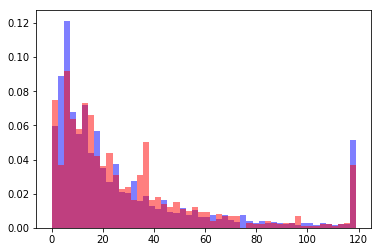

In [14]:
def plot_train_test_comp(feature):
    BINS = 50
    #data = reduce_train[reduce_train['accuracy_group'] == 3][feature]
    data = reduce_train[feature]
    train_mean = data.mean()
    perc_90 = np.percentile(data, 95)
    plt.hist(np.clip(data, 0, perc_90), bins=BINS, color='blue', alpha=0.5, weights=np.ones(len(data)) / len(data))
    data = reduce_test[feature] 
    test_mean = data.mean()
    ajust_factor = train_mean / test_mean
    plt.hist(np.clip(data * ajust_factor, 0, perc_90), bins=BINS, color='red', alpha=0.5, weights=np.ones(len(data)) / len(data))
    plt.show()

plot_train_test_comp('Clip')

In [15]:
total_features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in total_features if x not in ['accuracy_group', 'installation_id']]

In [16]:
added_features = [col for col in total_features if col in ['accuracy_group', 'installation_id','installation_session_count', 
                                                  'installation_duration_mean', 'installation_title_nunique', 
                                                  'installation_event_code_count_mean','session_title']]
add_train = reduce_train[added_features]
add_test = reduce_test[added_features]

In [21]:
to_exclude = []
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart Balancer (Assessment) -0.04020325710970116 -0.47065833333333346
003cd2ee 0.0 0.0
01ca3a3c 0.0004522328999434709 0.0
0ce40006 0.0008479366873940079 0.0
119b5b02 0.0002826455624646693 0.0
13f56524 0.04392312040700961 0.0
17ca3959 0.0 0.0
1b54d27f 0.0007348784624081402 0.0
29a42aea 0.004070096099491238 0.0
2ec694de 0.008988128886376484 0.0
4074bac2 0.0 0.0
5dc079d8 0.0 0.0
611485c5 0.0013566986998304127 0.0
6aeafed4 0.14703222159412097 0.008
7fd1ac25 0.01978518937252685 0.0
a8cc6fec 0.0 0.0
ab4ec3a4 0.0009044657998869418 0.0
bfc77bd6 0.012832108535895986 0.0
dcb1663e 0.0 0.0
e4d32835 0.0013001695873374789 0.0
eb2c19cd 0.17382702091577162 0.008
ecc6157f 0.007292255511588468 0.0
Air Show_4080 0.0 0.0
Bottle Filler (Activity)_2010 0.0 0.0
Bubble Bath_4080 0.004070096099491238 0.0
Bubble Bath_4090 0.14703222159412097 0.008
Bug Measurer (Activity)_4080 0.008988128886376484 0.0
Cart Balancer (Assessment)_4080 0.007292255511588468 0.0
Chest Sorter (Assessment)_4080 0.012832108535895986 

In [18]:
features = [x for x in features if x not in to_exclude]
reduce_train[features].shape

(17690, 855)

Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.03161	valid_1's rmse: 1.05369
[200]	training's rmse: 0.961382	valid_1's rmse: 1.00378
[300]	training's rmse: 0.926638	valid_1's rmse: 0.988074
[400]	training's rmse: 0.901959	valid_1's rmse: 0.981248
[500]	training's rmse: 0.882141	valid_1's rmse: 0.978693
[600]	training's rmse: 0.864837	valid_1's rmse: 0.97685
[700]	training's rmse: 0.849627	valid_1's rmse: 0.976052
[800]	training's rmse: 0.835456	valid_1's rmse: 0.975423
[900]	training's rmse: 0.822117	valid_1's rmse: 0.975282
[1000]	training's rmse: 0.809709	valid_1's rmse: 0.975241
Early stopping, best iteration is:
[973]	training's rmse: 0.812993	valid_1's rmse: 0.975091
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.02841	valid_1's rmse: 1.05952
[200]	training's rmse: 0.957863	valid_1's rmse: 1.01404
[300]	training's rmse: 0.922675	valid_1's rmse: 0.999719
[400]	training's rmse: 0.897863	val

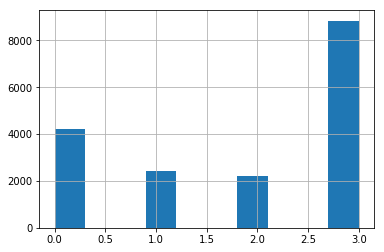

In [19]:
import warnings
warnings.filterwarnings("ignore")
y_lgb_pred_1,val_lgb_pred_1,feature_importance_1 =  Model1_LgbStratified(reduce_train, ajusted_test, features, 5)

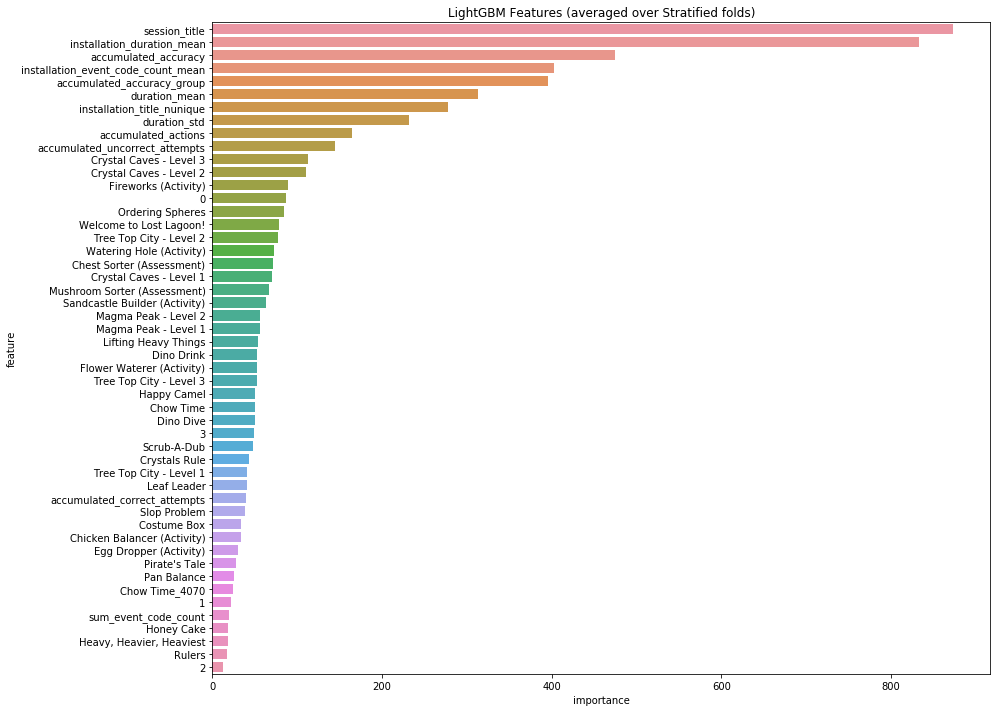

In [20]:
import seaborn as sns
cols = (feature_importance_1[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:300].index)
best_features_stratified = feature_importance_1.loc[feature_importance_1.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features_stratified[-50:].sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over Stratified folds)')
plt.tight_layout()

Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.03539	valid_1's rmse: 1.05632
[200]	training's rmse: 0.964612	valid_1's rmse: 1.00357
[300]	training's rmse: 0.92947	valid_1's rmse: 0.985917
[400]	training's rmse: 0.90494	valid_1's rmse: 0.976868
[500]	training's rmse: 0.884956	valid_1's rmse: 0.971348
[600]	training's rmse: 0.868034	valid_1's rmse: 0.96894
[700]	training's rmse: 0.852517	valid_1's rmse: 0.967657
[800]	training's rmse: 0.838228	valid_1's rmse: 0.966997
[900]	training's rmse: 0.824996	valid_1's rmse: 0.966685
[1000]	training's rmse: 0.812726	valid_1's rmse: 0.966259
[1100]	training's rmse: 0.801138	valid_1's rmse: 0.965855
Early stopping, best iteration is:
[1057]	training's rmse: 0.806246	valid_1's rmse: 0.965693
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.03431	valid_1's rmse: 1.06507
[200]	training's rmse: 0.963783	valid_1's rmse: 1.01083
[300]	training's rmse: 0.928154	val

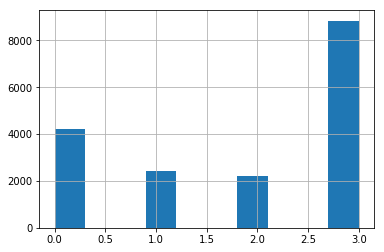

In [21]:
warnings.filterwarnings("ignore")
y_lgb_pred_2,val_lgb_pred_2,feature_importance_2 =  Model2_GroupKFold(reduce_train, ajusted_test, features, 5)

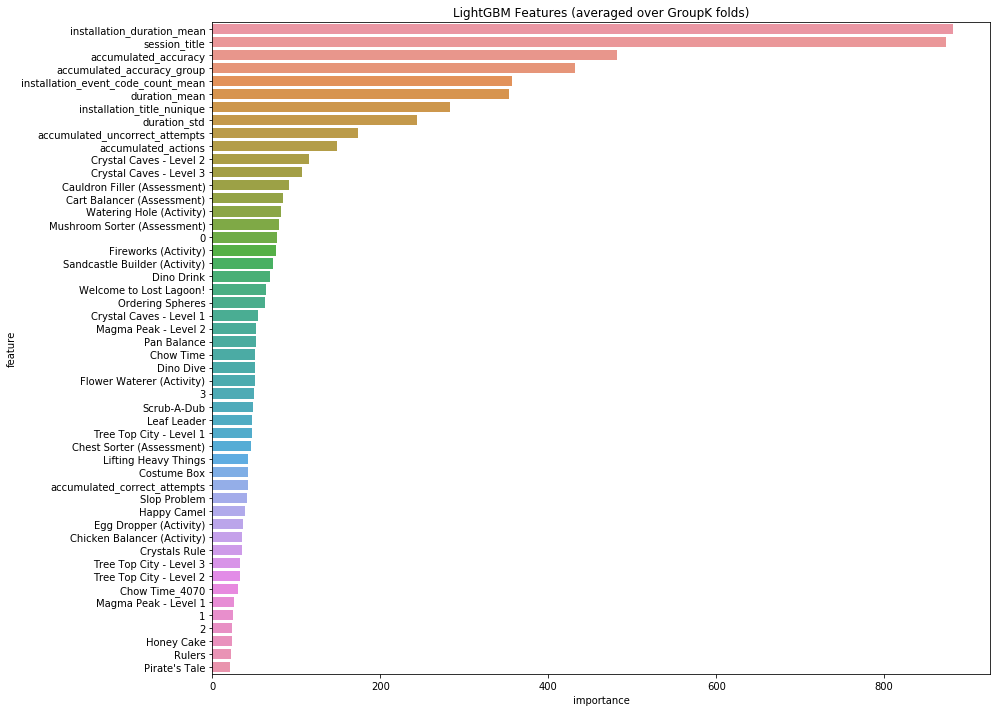

In [22]:
import seaborn as sns
cols = (feature_importance_2[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:300].index)
best_features_groupkfold = feature_importance_2.loc[feature_importance_2.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features_groupkfold[-50:].sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over GroupK folds)')
plt.tight_layout()

Let's make another filter and use adversarial validation to eliminate features. The main idea of adversarial validations is to train a ml model and check if the model can figure out if the data is from the train or test set.

If it can, this means that the data comes from another distribution and that's not a good thing.

Run Adverserial Validation on Group kfold

In [23]:
useful_features_group_K = best_features_groupkfold['feature'].tolist()
from sklearn import metrics

Since We already know the good features, lets filter them out before applying Adversarial technique

In [24]:
av_features = [col for col in useful_features_group_K if col not in ['installation_session_count', 
                                                  'installation_duration_mean', 'installation_title_nunique', 
                                                  'installation_event_code_count_mean','session_title']]

In [25]:
def run_av_groupk(reduce_train, reduce_test, usefull_features):
    
    tr_data = reduce_train.copy()
    tst_data = reduce_test.copy()
    tr_data['target'] = 0 
    tst_data['target'] = 1
    av_data = pd.concat([tr_data[[col for col in tr_data.columns if col not in ['accuracy_group']]], tst_data[[col for col in tst_data.columns if col not in ['accuracy_group']]]], axis = 0)
    
    # undersample majority class
    positive = av_data[av_data['target']==1]
    negative = av_data[av_data['target']==0]
    negative = negative.sample(int(negative.shape[0] * 0.5), random_state = 42)
    av_data = pd.concat([negative, positive], axis = 0)
    
    # reset index and shuffle
    av_data.reset_index(drop = True)
    from sklearn.utils import shuffle
    av_data = shuffle(av_data)
        
    params = {
            'learning_rate': 0.01, 
            'n_jobs': -1,
            'seed': 42,
            'objective':'binary',
            'boosting_type':'gbdt',
            'is_unbalance': True,
            'metric': 'auc',
        }
    
    # define a KFold strategy
    kf = GroupKFold(n_splits = 5)
    target = 'target'
    oof_pred = np.zeros(len(av_data))
    important_features = pd.DataFrame()
    fold_auc = []
    
    
    for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, groups = av_data['installation_id'])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = av_data[usefull_features].iloc[tr_ind], av_data[usefull_features].iloc[val_ind]
        y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 20, 
                         valid_sets = [train_set, val_set], verbose_eval = 100)
        
        fold_importance = pd.DataFrame()
        fold_importance['features'] = usefull_features
        fold_importance['importance'] = model.feature_importance()
        important_features = pd.concat([important_features, fold_importance], axis = 0)
        
        oof_pred[val_ind] = model.predict(x_val)
        fold_auc.append(metrics.roc_auc_score(y_train, model.predict(x_train)))
        
    print('Our mean train roc auc score is :', np.mean(fold_auc))
    print('Our oof roc auc score is :', metrics.roc_auc_score(av_data[target], oof_pred))
    return important_features

important_features = run_av_groupk(reduce_train, reduce_test, av_features)

Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	training's auc: 0.846958	valid_1's auc: 0.690466
Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	training's auc: 0.812047	valid_1's auc: 0.701057
Fold 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[9]	training's auc: 0.816415	valid_1's auc: 0.705453
Fold 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.806869	valid_1's auc: 0.695162
Fold 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	training's auc: 0.85282	valid_1's auc: 0.685907
Our mean train roc auc score is : 0.8270216692339794
Our oof roc auc score is : 0.6397761447145278


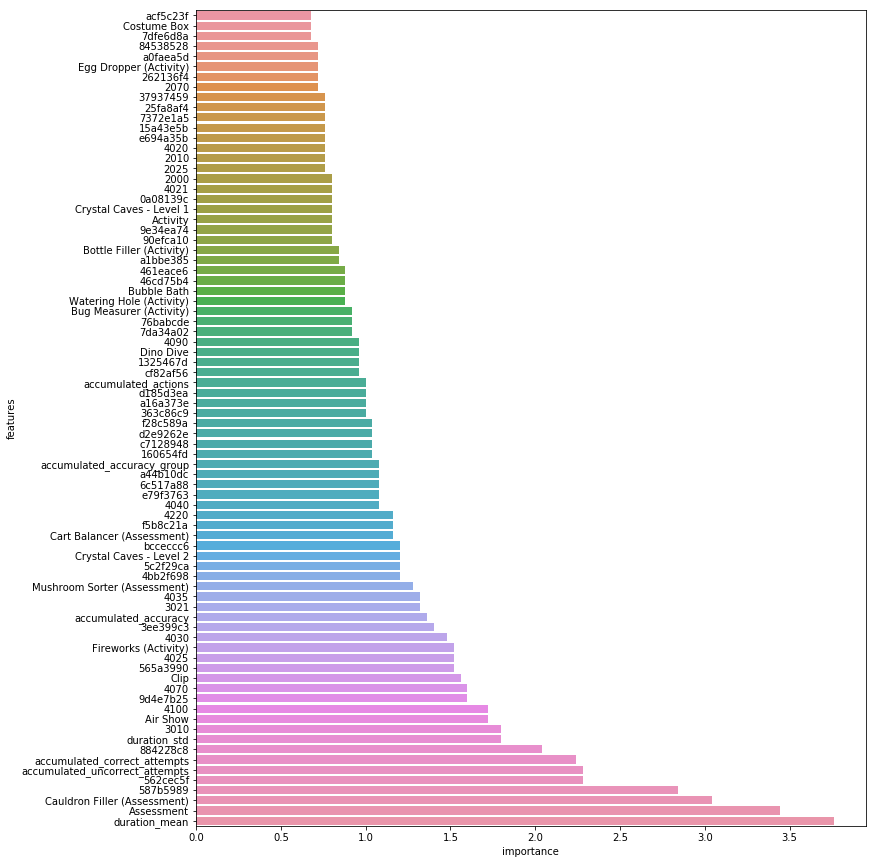

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12,15))
important_features = important_features.groupby('features')['importance'].mean().reset_index().sort_values('importance')
sns.barplot(important_features['importance'][-80:], important_features['features'][-80:])

Much better, our model can still detect train and test. Nevertheless want to try and check the results.

Let's build a function that drop one feature and check if the oof validation falls, if it falls we drop it.

In [27]:
def run_av_groupk_stage_2(reduce_train, reduce_test, usefull_features):
    
    tr_data = reduce_train.copy()
    tst_data = reduce_test.copy()
    tr_data['target'] = 0 
    tst_data['target'] = 1
    av_data = pd.concat([tr_data[[col for col in tr_data.columns if col not in ['accuracy_group']]], tst_data[[col for col in tst_data.columns if col not in ['accuracy_group']]]], axis = 0)
    
     # undersample majority class
    positive = av_data[av_data['target']==1]
    negative = av_data[av_data['target']==0]
    negative = negative.sample(int(negative.shape[0] * 0.5), random_state = 42)
    av_data = pd.concat([negative, positive], axis = 0)
    
    # reset index and shuffle
    av_data.reset_index(drop = True)
    from sklearn.utils import shuffle
    av_data = shuffle(av_data)
        
        
    params = {
            'learning_rate': 0.01, 
            'n_jobs': -1,
            'seed': 42,
            'objective':'binary',
            'boosting_type':'gbdt',
            'is_unbalance': True,
            'metric': 'auc'
        }
    
    # define a KFold strategy
    kf = GroupKFold(n_splits = 5)
    target = 'target'
    
    oof_pred = np.zeros(len(av_data))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, groups = av_data['installation_id'])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = av_data[usefull_features].iloc[tr_ind], av_data[usefull_features].iloc[val_ind]
        y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 20, 
                         valid_sets = [train_set, val_set], verbose_eval = 100)
    
        
        oof_pred[val_ind] = model.predict(x_val)
    
    score = metrics.roc_auc_score(av_data[target], oof_pred)
    
    iter_features = usefull_features[::-1].copy()
    drop_features = []
    for i in iter_features:
        oof_pred = np.zeros(len(av_data))
        check_features = [col for col in iter_features if col not in drop_features + [i]]
        print('Checking feature:', i)
        for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, groups = av_data['installation_id'])):
            x_train, x_val = av_data[check_features].iloc[tr_ind], av_data[check_features].iloc[val_ind]
            y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
            train_set = lgb.Dataset(x_train, y_train)
            val_set = lgb.Dataset(x_val, y_val)

            model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 20, 
                             valid_sets = [train_set, val_set], verbose_eval = False)


            oof_pred[val_ind] = model.predict(x_val)
            
        rauc = metrics.roc_auc_score(av_data[target], oof_pred)
            
        if rauc < score:
            print('Dropping feature: ', i)
            score = rauc
            drop_features.append(i)
        else:
            print('Feature {} is usefull'.format(i))
            
        print('Out best roc auc score is :', score)
            
        print('-'*50)
        print('_'*50)
            
    usefull_features = [col for col in usefull_features if col not in drop_features]
    return usefull_features

usefull_features_groupk = run_av_groupk_stage_2(reduce_train, reduce_test, list(important_features['features']))

Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	training's auc: 0.833445	valid_1's auc: 0.690609
Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	training's auc: 0.812049	valid_1's auc: 0.701034
Fold 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[9]	training's auc: 0.816415	valid_1's auc: 0.705498
Fold 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.806869	valid_1's auc: 0.695165
Fold 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	training's auc: 0.861021	valid_1's auc: 0.686662
Checking feature: duration_mean
Feature duration_mean is usefull
Out best roc auc score is : 0.643680836630865
--------------------------------------------------
__________________________________________________
Chec

In [28]:
reduce_train[usefull_features_groupk].shape

(17690, 277)

In [29]:
reduce_test[usefull_features_groupk].shape

(1000, 277)

Run Adverserial Validation on Stratified kfold

In [30]:
useful_features_Stratified = best_features_stratified['feature'].tolist()
from sklearn import metrics

In [31]:
av_features = [col for col in useful_features_Stratified if col not in ['installation_session_count', 
                                                  'installation_duration_mean', 'installation_title_nunique', 
                                                  'installation_event_code_count_mean','session_title']]

In [32]:
def run_av_Stratified(reduce_train, reduce_test, usefull_features):
    
    tr_data = reduce_train.copy()
    tst_data = reduce_test.copy()
    tr_data['target'] = 0 
    tst_data['target'] = 1
    av_data = pd.concat([tr_data[[col for col in tr_data.columns if col not in ['accuracy_group']]], tst_data[[col for col in tst_data.columns if col not in ['accuracy_group']]]], axis = 0)
    
    # undersample majority class
    positive = av_data[av_data['target']==1]
    negative = av_data[av_data['target']==0]
    negative = negative.sample(int(negative.shape[0] * 0.5), random_state = 42)
    av_data = pd.concat([negative, positive], axis = 0)
    
    # reset index and shuffle
    av_data.reset_index(drop = True)
    from sklearn.utils import shuffle
    av_data = shuffle(av_data)
        
    params = {
            'learning_rate': 0.01, 
            'n_jobs': -1,
            'seed': 42,
            'objective':'binary',
            'boosting_type':'gbdt',
            'is_unbalance': True,
            'metric': 'auc',
        }
    
    # define a KFold strategy
    kf = StratifiedKFold(n_splits = 5)
    target = 'target'
    oof_pred = np.zeros(len(av_data))
    important_features = pd.DataFrame()
    fold_auc = []
    
    
    for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data,av_data[target])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = av_data[usefull_features].iloc[tr_ind], av_data[usefull_features].iloc[val_ind]
        y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 20, 
                         valid_sets = [train_set, val_set], verbose_eval = 100)
        
        fold_importance = pd.DataFrame()
        fold_importance['features'] = usefull_features
        fold_importance['importance'] = model.feature_importance()
        important_features = pd.concat([important_features, fold_importance], axis = 0)
        
        oof_pred[val_ind] = model.predict(x_val)
        fold_auc.append(metrics.roc_auc_score(y_train, model.predict(x_train)))
        
    print('Our mean train roc auc score is :', np.mean(fold_auc))
    print('Our oof roc auc score is :', metrics.roc_auc_score(av_data[target], oof_pred))
    return important_features

important_features_2 = run_av_Stratified(reduce_train, reduce_test, av_features)

Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	training's auc: 0.852219	valid_1's auc: 0.689757
Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	training's auc: 0.827736	valid_1's auc: 0.699365
Fold 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	training's auc: 0.805941	valid_1's auc: 0.69065
Fold 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	training's auc: 0.845116	valid_1's auc: 0.712585
Fold 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.780561	valid_1's auc: 0.698567
Our mean train roc auc score is : 0.8223147081684568
Our oof roc auc score is : 0.6503427925381571


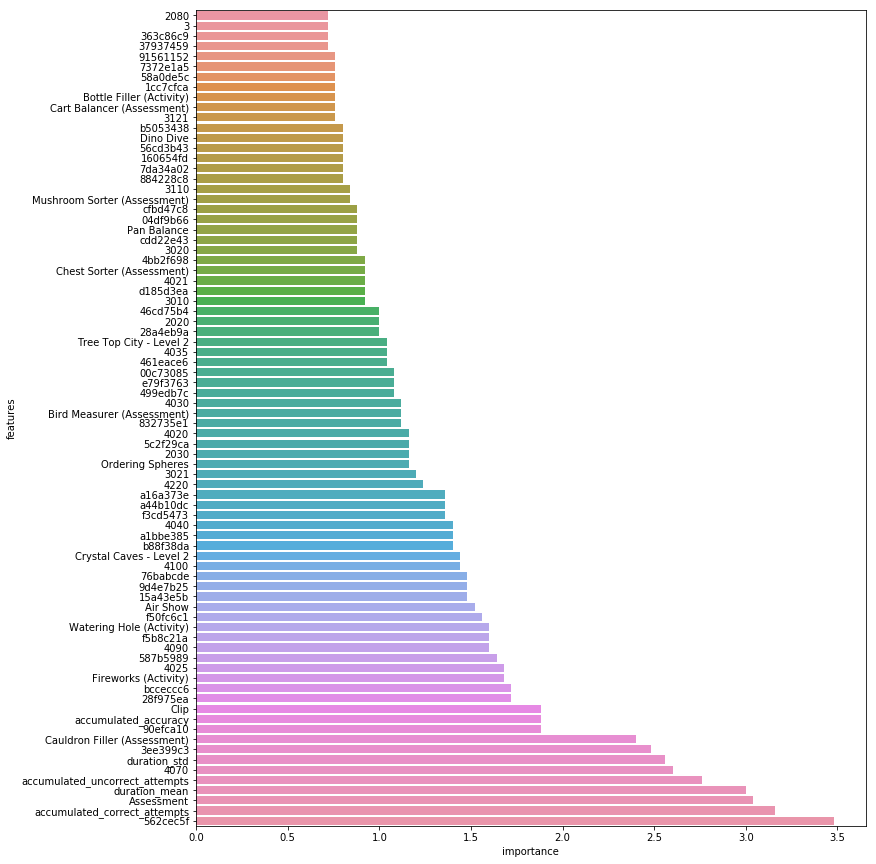

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12,15))
important_features_2 = important_features_2.groupby('features')['importance'].mean().reset_index().sort_values('importance')
sns.barplot(important_features_2['importance'][-80:], important_features_2['features'][-80:])

In [34]:
def run_av_stratify_stage_2(reduce_train, reduce_test, usefull_features):
    
    tr_data = reduce_train.copy()
    tst_data = reduce_test.copy()
    tr_data['target'] = 0 
    tst_data['target'] = 1
    av_data = pd.concat([tr_data[[col for col in tr_data.columns if col not in ['accuracy_group']]], tst_data[[col for col in tst_data.columns if col not in ['accuracy_group']]]], axis = 0)
    
     # undersample majority class
    positive = av_data[av_data['target']==1]
    negative = av_data[av_data['target']==0]
    negative = negative.sample(int(negative.shape[0] * 0.5), random_state = 42)
    av_data = pd.concat([negative, positive], axis = 0)
    
    # reset index and shuffle
    av_data.reset_index(drop = True)
    from sklearn.utils import shuffle
    av_data = shuffle(av_data)
        
        
    params = {
            'learning_rate': 0.01, 
            'n_jobs': -1,
            'seed': 42,
            'objective':'binary',
            'boosting_type':'gbdt',
            'is_unbalance': True,
            'metric': 'auc'
        }
    
    # define a KFold strategy
    kf = StratifiedKFold(n_splits = 5)
    target = 'target'
    
    oof_pred = np.zeros(len(av_data))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data,av_data['target'])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = av_data[usefull_features].iloc[tr_ind], av_data[usefull_features].iloc[val_ind]
        y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 20, 
                         valid_sets = [train_set, val_set], verbose_eval = 100)
    
        
        oof_pred[val_ind] = model.predict(x_val)
    
    score = metrics.roc_auc_score(av_data[target], oof_pred)
    
    iter_features = usefull_features[::-1].copy()
    drop_features = []
    for i in iter_features:
        oof_pred = np.zeros(len(av_data))
        check_features = [col for col in iter_features if col not in drop_features + [i]]
        print('Checking feature:', i)
        for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data,av_data['target'])):
            x_train, x_val = av_data[check_features].iloc[tr_ind], av_data[check_features].iloc[val_ind]
            y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
            train_set = lgb.Dataset(x_train, y_train)
            val_set = lgb.Dataset(x_val, y_val)

            model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 20, 
                             valid_sets = [train_set, val_set], verbose_eval = False)


            oof_pred[val_ind] = model.predict(x_val)
            
        rauc = metrics.roc_auc_score(av_data[target], oof_pred)
            
        if rauc < score:
            print('Dropping feature: ', i)
            score = rauc
            drop_features.append(i)
        else:
            print('Feature {} is usefull'.format(i))
            
        print('Out best roc auc score is :', score)
            
        print('-'*50)
        print('_'*50)
            
    usefull_features = [col for col in usefull_features if col not in drop_features]
    return usefull_features

usefull_features_stratify = run_av_stratify_stage_2(reduce_train, reduce_test, list(important_features_2['features']))

Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	training's auc: 0.856602	valid_1's auc: 0.699707
Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	training's auc: 0.825049	valid_1's auc: 0.696118
Fold 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	training's auc: 0.837812	valid_1's auc: 0.702075
Fold 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	training's auc: 0.826793	valid_1's auc: 0.693878
Fold 5
Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.879256	valid_1's auc: 0.709339
Early stopping, best iteration is:
[101]	training's auc: 0.879634	valid_1's auc: 0.709494
Checking feature: 562cec5f
Feature 562cec5f is usefull
Out best roc auc score is : 0.6712498586772188
--------------------------------------------------
______

In [35]:
reduce_train[usefull_features_stratify].shape

(17690, 275)

In [36]:
reduce_test[usefull_features_stratify].shape

(1000, 275)

Concatenate the Features

In [37]:
Strat_train_X = pd.concat([reduce_train[usefull_features_stratify],add_train],axis=1)
Strat_test_X = pd.concat([reduce_test[usefull_features_stratify],add_test], axis=1)
Groupk_train_X = pd.concat([reduce_train[usefull_features_groupk],add_train], axis=1)
Groupk_test_X = pd.concat([reduce_test[usefull_features_groupk],add_test], axis=1)

Export to CSV

In [38]:
Strat_train_X.to_csv('Strat_train_X.csv', index=False)
Strat_test_X.to_csv('Strat_test_X.csv', index=False)
Groupk_train_X.to_csv('Groupk_train_X.csv', index=False)
Groupk_test_X.to_csv('Groupk_test_X.csv', index=False)

print ("The Data is Exported Successfully")

The Data is Exported Successfully


In [39]:
Strat_train_X.shape

(17690, 282)

In [40]:
Groupk_train_X.shape

(17690, 284)

In [41]:
Strat_test_X.shape

(1000, 282)

In [42]:
Groupk_test_X.shape

(1000, 284)